In [ ]:
def preprocess_images(images):
    """
    Normalize the images to [-1, 1] range
    """
    num_images, width, height = images.shape
    images = images.reshape(num_images, 1, width, height).astype('float32')
    images = (images - 127.5) / 127.5
    return images

def load_data(data_arrays, batch_size, shuffle=True):
    """
    Constructs a PyTorch DataLoader with shuffling and batching.
    """
    # Convert NumPy arrays to PyTorch tensors
    tensors = [torch.from_numpy(arr) for arr in data_arrays]
    dataset = torch.utils.data.TensorDataset(*tensors)

    if shuffle:
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    else:
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return dataloader



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import glob
import os
import PIL
import imageio
import time

from IPython import display
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

# Extract images and labels
train_x, train_y = train_dataset.data.numpy(), train_dataset.targets.numpy()
test_x, test_y = test_dataset.data.numpy(), test_dataset.targets.numpy()

print('Train', train_x.shape, train_y.shape)
print('Test', test_x.shape, test_y.shape)


Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


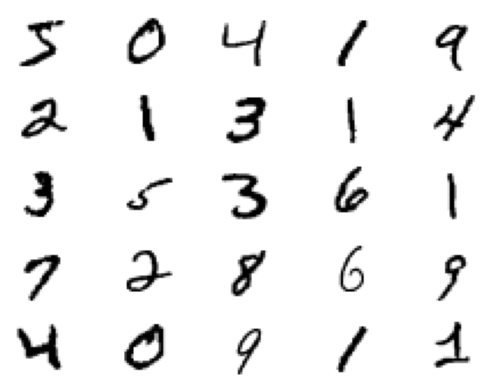

In [ ]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(train_x[i], cmap='gray_r')
plt.show()

In [ ]:
train_images = preprocess_images(train_x)
train_labels = train_y

# Define buffer size and batch size
buffer_size = 60000
batch_size = 256

# Load data into DataLoader
trainloader = load_data([train_images, train_labels], batch_size, shuffle=True)

# Get a batch of training data
train_images_batch, train_labels_batch = next(iter(trainloader))
print('Train', train_images_batch.shape, train_labels_batch.shape)

Train torch.Size([256, 1, 28, 28]) torch.Size([256])


In [ ]:
class G_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, strides=2, padding=2):
        super(G_block, self).__init__()
        self.conv2d_trans = nn.ConvTranspose2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=strides, padding=padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.activation(self.batch_norm(self.conv2d_trans(x)))

n_g = 256
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 7 * 7 * n_g, bias=False),
            nn.BatchNorm1d(7 * 7 * n_g),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (n_g, 7, 7)),
            G_block(in_channels=n_g, out_channels=n_g // 2, kernel_size=5, strides=1, padding=2),
            G_block(in_channels=n_g // 2, out_channels=n_g // 4, kernel_size=5, strides=2, padding=2),
            nn.ConvTranspose2d(n_g // 4, 1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the generator
net_G = Generator()

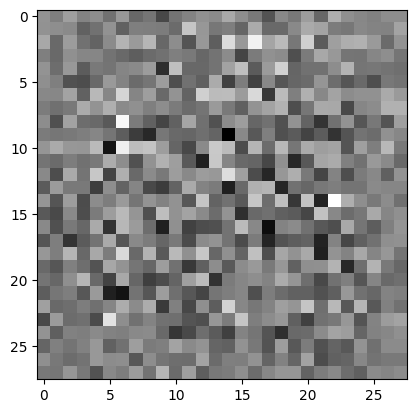

In [ ]:
noise = torch.randn(1, 100)

# Set the generator to evaluation mode
net_G.eval()

# Generate an image using the generator
with torch.no_grad():
    generated_image = net_G(noise)

# Convert the generated image to a format suitable for plotting
generated_image = generated_image.squeeze().detach().cpu().numpy()

# Plot the generated image
plt.imshow(generated_image, cmap='gray')
plt.show()

In [ ]:
from torchsummary import summary

# Print the summary of the generator model
summary(net_G, (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 12544]       1,254,400
       BatchNorm1d-2                [-1, 12544]          25,088
         LeakyReLU-3                [-1, 12544]               0
         Unflatten-4            [-1, 256, 7, 7]               0
   ConvTranspose2d-5            [-1, 128, 7, 7]         819,200
       BatchNorm2d-6            [-1, 128, 7, 7]             256
         LeakyReLU-7            [-1, 128, 7, 7]               0
           G_block-8            [-1, 128, 7, 7]               0
   ConvTranspose2d-9           [-1, 64, 13, 13]         204,800
      BatchNorm2d-10           [-1, 64, 13, 13]             128
        LeakyReLU-11           [-1, 64, 13, 13]               0
          G_block-12           [-1, 64, 13, 13]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]           1,024
             Tanh-14            [-1, 1,

In [ ]:
class D_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, strides=2, padding=1, alpha=0.2, dropout=0.3):
        super(D_block, self).__init__()
        self.conv2d = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=strides, padding=padding, bias=False)
        self.activation = nn.LeakyReLU(alpha, inplace=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.activation(self.conv2d(x)))

n_d = 64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            D_block(in_channels=1, out_channels=n_d, kernel_size=5, strides=2, padding=2),
            D_block(in_channels=n_d, out_channels=n_d * 2, kernel_size=5, strides=2, padding=2),
            nn.Flatten(),
            nn.Linear(n_d * 2 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the discriminator
net_D = Discriminator()

In [ ]:
generated_image_tensor = torch.tensor(generated_image).unsqueeze(0).unsqueeze(0)

# Generate a decision for the generated image
with torch.no_grad():
    decision = net_D(generated_image_tensor)

print(decision)  # without training...

tensor([[0.4908]])


In [ ]:
summary(net_D, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,600
         LeakyReLU-2           [-1, 64, 14, 14]               0
           Dropout-3           [-1, 64, 14, 14]               0
           D_block-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 7, 7]         204,800
         LeakyReLU-6            [-1, 128, 7, 7]               0
           Dropout-7            [-1, 128, 7, 7]               0
           D_block-8            [-1, 128, 7, 7]               0
           Flatten-9                 [-1, 6272]               0
           Linear-10                    [-1, 1]           6,273
          Sigmoid-11                    [-1, 1]               0
Total params: 212,673
Trainable params: 212,673
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
def train(net_D, net_G, data_iter, hyperparams, seed, num_epochs=20):
    """
    Trains a GAN with hyperparameter tuning.

    Args:
      net_D: Discriminator model.
      net_G: Generator model.
      data_iter: Data iterator.
      hyperparams: Dictionary containing values of hyperparameters.
        - lr_D: learning rate for discriminator.
        - lr_G: learning rate for generator.
        - num_discriminator_updates: number of discriminator updates per batch.
        - latent_dim: dimension of latent space.
      num_epochs: Number of epochs. Default is set at 20.
    """
    loss = nn.BCELoss()

    # Initialize weights
    def weights_init(m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

    net_D.apply(weights_init)
    net_G.apply(weights_init)

    optimizer_D = optim.Adam(net_D.parameters(), lr=hyperparams["lr_D"])
    optimizer_G = optim.Adam(net_G.parameters(), lr=hyperparams["lr_G"])

    best_loss_D = float('inf')
    best_epoch = 0

    for epoch in range(num_epochs):
        loss_D_total, loss_G_total, num_examples = 0., 0., 0
        epoch_start_time = time.time()  # time for each epoch

        for X, y in data_iter:
            batch_size = X.size(0)

            # Train discriminator (multiple times if the user wants)
            for _ in range(hyperparams["num_discriminator_updates"]):
                Z = torch.randn(batch_size, hyperparams["latent_dim"], device=X.device)
                fake_X = net_G(Z)
                real_Y = net_D(X)
                fake_Y = net_D(fake_X.detach())
                real_loss = loss(real_Y, torch.ones_like(real_Y))
                fake_loss = loss(fake_Y, torch.zeros_like(fake_Y))
                loss_D = (real_loss + fake_loss) / 2

                optimizer_D.zero_grad()
                loss_D.backward()
                optimizer_D.step()

                loss_D_total += loss_D.item()
                num_examples += batch_size

            # Train generator
            Z = torch.randn(batch_size, hyperparams["latent_dim"], device=X.device)
            fake_X = net_G(Z)
            fake_Y = net_D(fake_X)
            loss_G = loss(fake_Y, torch.ones_like(fake_Y))

            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            loss_G_total += loss_G.item()

        # Calculate average losses and print
        loss_D_avg = loss_D_total / num_examples
        loss_G_avg = loss_G_total / num_examples

        # Early stopping based on discriminator loss
        if loss_D_avg < best_loss_D:
            best_loss_D = loss_D_avg
            best_epoch = epoch

        print(f'Epoch {epoch+1}: loss_D {loss_D_avg:.3f}, loss_G {loss_G_avg:.3f}, {num_examples} examples')
        epoch_end_time = time.time()  # time for each epoch
        epoch_time = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")

        if (epoch + 1) % 25 == 0:
            model_name = f"generator_MNIST_epoch_{epoch + 1}.pth"
            torch.save(net_G.state_dict(), f"/content/gdrive/My Drive/{model_name}")
            print(f"Model saved to: {model_name}")

        with torch.no_grad():
            generated_images = net_G(seed).cpu()
            for i in range(generated_images.size(0)):
                plt.subplot(5, 5, 1 + i)
                plt.axis('off')
                plt.imshow(generated_images[i, 0] * 127.5 + 127.5, cmap='gray')
            plt.suptitle(f"Generated Images - Epoch: {epoch + 1}")
            if (epoch + 1) % 20 == 0:
                plt.savefig(f"/content/gdrive/MyDrive/generated_images_MNIST_epoch_{epoch + 1}.png")
            plt.show()

    # Print best epoch based on discriminator loss
    print(f"Best epoch based on discriminator loss: {best_epoch + 1}")

In [ ]:
num_epochs = 200
hyperparams = {
    'lr_D': 0.0001,
    'lr_G': 0.0001,
    'num_discriminator_updates': 2,
    'latent_dim': 100
}

# For visual testing while in training
seed = torch.randn(25, hyperparams["latent_dim"])

start_time = time.time()  # for timing
train(net_D, net_G, trainloader, hyperparams, seed, num_epochs)

end_time = time.time()
total_training_time = end_time - start_time  # calculating how much time was passed since starting the training loop
print(f"Total training time: {total_training_time:.2f} seconds")

KeyboardInterrupt: 